# ANN Model with Penalty

In [1]:
pip install numpy pandas scikit-learn tensorflow 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# LIBRARIES
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras 
from tensorflow.keras import layers
import glob, re
import tensorflow as tf
import keras.backend as K
#from tensorflow.keras.models import Sequential 
#from tensorflow.keras.layers import Dense

# 1.) Penalty Function

In [3]:
# === PENALTY-AWARE CUSTOM LOSS FUNCTION WITH LOGGING ===

# Defining the loss and metrics 
import tensorflow as tf
import keras.backend as K

# How much weight to give to the penalty
penalty_weight = 0.1  # Increase to punish large errors more, decrease to punish less



# Metric that will track the average penalty for each epoch
penalty_metric = tf.keras.metrics.Mean(name="penalty_mean")

# Custom loss that combines MSE with an L2 (Euclidean) penalty , while logging the penalty value vias a Keras metric
def penalty_aware_loss(y_true, y_pred):
    # Compute the MSE over the last axis
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    # Compute the euclidean norm between predictions and actual values
    penalty = tf.norm(y_pred - y_true, ord='euclidean', axis=-1)
    # Update custom metric so we can inspect the penalty each epoch 
    penalty_metric.update_state(penalty)

    # Return the combined loss 
    return mse + penalty_weight * penalty

# Custom callback to print average penalty at the end of each epoch
class PenaltyLoggingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # get the current average penalty from our metric
        avg_penalty = penalty_metric.result().numpy()
        print(f" Epoch {epoch+1}: Penalty (Euclidean) = {avg_penalty:.4f}")
        # Reset metric so it starts fresh for the next epoch
        penalty_metric.reset_state()

# 2.) Loading the data

In [4]:
pattern = "processed/*_test-*_range.csv"
all_files = sorted(
    glob.glob(pattern),
    key = lambda fp: int(re.search(r"test-(\d+)_range", fp).group(1)))

In [5]:
train_files = []
validation_files = []

In [6]:
for fp in all_files:
    num = int(re.search(r"test-(\d+)_range", fp).group(1))
    if num in (7, 12):
        validation_files.append(fp)

    else:
        train_files.append(fp)

In [7]:
train_dfs = [pd.read_csv(fp) for fp in train_files]
combined_df = pd.concat(train_dfs, ignore_index = True)

val_dfs = [pd.read_csv(fp) for fp in validation_files]
df_validate = pd.concat(val_dfs, ignore_index=True)

In [8]:
combined_df

,time,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,X,Z,flow-time
0,0.0,-107.526882,-226.000000,222.222222,175.627240,268.817204,-14.336918,86.021505,-57.347670,-78.853047,107.526882,-688.172043,-4505.376344,-4856.630824,258.064516,-408.602150,-25.089606,-4.856481,-4.322118,NaN
1,1.0,-107.526882,-151.000000,71.684588,175.627240,193.548387,60.931900,10.752688,-57.347670,-78.853047,32.258065,-612.903226,-4430.107527,-4781.362007,258.064516,-333.333333,-100.358423,-4.856481,-4.322118,NaN
2,2.0,-107.526882,-75.300000,71.684588,250.896057,193.548387,60.931900,10.752688,-57.347670,-78.853047,107.526882,-537.634409,-4354.838710,-4630.824373,182.795699,-333.333333,-25.089606,-4.856481,-4.322118,NaN
3,3.0,-107.526882,-150.537634,222.222222,326.164875,268.817204,-14.336918,161.290323,-57.347670,-78.853047,107.526882,-537.634409,-4354.838710,-4706.093190,182.795699,-258.064516,-25.089606,-4.856481,-4.322118,NaN
4,4.0,-32.258065,-75.268817,71.684588,326.164875,193.548387,60.931900,311.827957,-57.347670,-154.121864,107.526882,-537.634409,-4279.569892,-4630.824373,107.526882,-182.795699,50.179211,-4.856481,-4.322118,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725495,NaN,0.000000,791.486938,857.347656,804.698181,782.696045,777.723694,968.346802,878.197754,716.407104,641.137146,565.122559,387.138977,353.733185,571.289795,563.687805,631.462952,-5.186691,-4.322118,1059.9751
725496,NaN,0.000000,791.434204,857.295593,804.650879,782.664856,777.730225,968.296204,878.228638,716.427673,641.257263,565.125793,387.131805,353.731049,571.305237,563.693787,631.473022,-5.186691,-4.322118,1059.9801
725497,NaN,0.000000,791.381348,857.243408,804.603638,782.633789,777.737183,968.245544,878.259277,716.448364,641.377380,565.129028,387.124634,353.728912,571.320618,563.699829,631.483093,-5.186691,-4.322118,1059.9851
725498,NaN,0.000000,791.328613,857.191345,804.556152,782.602722,777.743835,968.194885,878.290222,716.468933,641.497620,565.132446,387.117432,353.726868,571.336121,563.705750,631.493103,-5.186691,-4.322118,1059.9901


In [9]:
combined_df.isnull().sum()

time         722497
p1                0
p2                0
p3                0
p4                0
p5                0
p6                0
p7                0
p8                0
p9                0
p10               0
p11               0
p12               0
p13               0
p14               0
p15               0
p16               0
X                 0
Z                 0
flow-time      3003
dtype: int64

In [10]:
combined_df['time_combined'] = combined_df['time'].fillna(combined_df['flow-time'])
combined_df = combined_df.drop(columns = ['time', 'flow-time'])
combined_df = combined_df.rename(columns = {'time_combined': 'time'})

combined_df = combined_df.dropna(subset = ['time'])

print(combined_df.isnull().sum())

p1      0
p2      0
p3      0
p4      0
p5      0
p6      0
p7      0
p8      0
p9      0
p10     0
p11     0
p12     0
p13     0
p14     0
p15     0
p16     0
X       0
Z       0
time    0
dtype: int64


In [11]:
combined_df

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,X,Z,time
0,-107.526882,-226.000000,222.222222,175.627240,268.817204,-14.336918,86.021505,-57.347670,-78.853047,107.526882,-688.172043,-4505.376344,-4856.630824,258.064516,-408.602150,-25.089606,-4.856481,-4.322118,0.0000
1,-107.526882,-151.000000,71.684588,175.627240,193.548387,60.931900,10.752688,-57.347670,-78.853047,32.258065,-612.903226,-4430.107527,-4781.362007,258.064516,-333.333333,-100.358423,-4.856481,-4.322118,1.0000
2,-107.526882,-75.300000,71.684588,250.896057,193.548387,60.931900,10.752688,-57.347670,-78.853047,107.526882,-537.634409,-4354.838710,-4630.824373,182.795699,-333.333333,-25.089606,-4.856481,-4.322118,2.0000
3,-107.526882,-150.537634,222.222222,326.164875,268.817204,-14.336918,161.290323,-57.347670,-78.853047,107.526882,-537.634409,-4354.838710,-4706.093190,182.795699,-258.064516,-25.089606,-4.856481,-4.322118,3.0000
4,-32.258065,-75.268817,71.684588,326.164875,193.548387,60.931900,311.827957,-57.347670,-154.121864,107.526882,-537.634409,-4279.569892,-4630.824373,107.526882,-182.795699,50.179211,-4.856481,-4.322118,4.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725495,0.000000,791.486938,857.347656,804.698181,782.696045,777.723694,968.346802,878.197754,716.407104,641.137146,565.122559,387.138977,353.733185,571.289795,563.687805,631.462952,-5.186691,-4.322118,1059.9751
725496,0.000000,791.434204,857.295593,804.650879,782.664856,777.730225,968.296204,878.228638,716.427673,641.257263,565.125793,387.131805,353.731049,571.305237,563.693787,631.473022,-5.186691,-4.322118,1059.9801
725497,0.000000,791.381348,857.243408,804.603638,782.633789,777.737183,968.245544,878.259277,716.448364,641.377380,565.129028,387.124634,353.728912,571.320618,563.699829,631.483093,-5.186691,-4.322118,1059.9851
725498,0.000000,791.328613,857.191345,804.556152,782.602722,777.743835,968.194885,878.290222,716.468933,641.497620,565.132446,387.117432,353.726868,571.336121,563.705750,631.493103,-5.186691,-4.322118,1059.9901


In [12]:
# Unseen Data
df_validate

,flow-time,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,X,Z
0,300.0000,19.198589,21.621674,21.358006,20.414961,21.041689,20.644730,20.664330,19.751699,16.220421,15.866580,17.026928,17.400671,17.077269,18.282455,15.633269,15.983516,-7.538065,-5.166719
1,300.0001,19.198587,21.621670,21.358004,20.414955,21.041689,20.644728,20.664326,19.751694,16.220417,15.866578,17.026926,17.400665,17.077265,18.282480,15.633268,15.983514,-7.538065,-5.166719
2,300.0002,19.198586,21.621664,21.357998,20.414951,21.041687,20.644724,20.664320,19.751690,16.220415,15.866573,17.026924,17.400663,17.077259,18.282511,15.633268,15.983511,-7.538065,-5.166719
3,300.0003,19.198584,21.621660,21.357994,20.414946,21.041687,20.644724,20.664314,19.751686,16.220415,15.866570,17.026924,17.400660,17.077255,18.282532,15.633266,15.983510,-7.538065,-5.166719
4,300.0004,19.198584,21.621658,21.357994,20.414944,21.041687,20.644724,20.664312,19.751682,16.220415,15.866568,17.026922,17.400660,17.077253,18.282555,15.633266,15.983507,-7.538065,-5.166719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210768,999.9580,0.672068,0.000000,1121.263428,1115.966431,1162.688965,1044.396729,1187.366455,1170.466309,4.814718,0.036940,810.533569,3249.333984,2454.925781,3635.814209,4138.591309,4521.295410,-4.856481,-4.322118
210769,999.9680,0.672087,0.000000,1121.266357,1115.972534,1162.691162,1044.400146,1187.375244,1170.469360,4.814291,0.036951,810.519714,3249.360840,2454.945068,3635.873291,4138.637207,4521.345215,-4.856481,-4.322118
210770,999.9780,0.672072,0.000000,1121.269653,1115.978271,1162.693726,1044.403564,1187.384155,1170.472168,4.813863,0.036962,810.505737,3249.387451,2454.964355,3635.932617,4138.683594,4521.395020,-4.856481,-4.322118
210771,999.9880,0.672060,0.000000,1121.272827,1115.984375,1162.696411,1044.406982,1187.393311,1170.474854,4.813434,0.036973,810.491699,3249.414062,2454.983398,3635.991699,4138.729980,4521.444336,-4.856481,-4.322118


In [13]:
df_validate['flow-time'] = df_validate.pop('flow-time')

In [14]:
df_validate = df_validate.rename(columns = {'flow-time': 'time'})
df_validate

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,X,Z,time
0,19.198589,21.621674,21.358006,20.414961,21.041689,20.644730,20.664330,19.751699,16.220421,15.866580,17.026928,17.400671,17.077269,18.282455,15.633269,15.983516,-7.538065,-5.166719,300.0000
1,19.198587,21.621670,21.358004,20.414955,21.041689,20.644728,20.664326,19.751694,16.220417,15.866578,17.026926,17.400665,17.077265,18.282480,15.633268,15.983514,-7.538065,-5.166719,300.0001
2,19.198586,21.621664,21.357998,20.414951,21.041687,20.644724,20.664320,19.751690,16.220415,15.866573,17.026924,17.400663,17.077259,18.282511,15.633268,15.983511,-7.538065,-5.166719,300.0002
3,19.198584,21.621660,21.357994,20.414946,21.041687,20.644724,20.664314,19.751686,16.220415,15.866570,17.026924,17.400660,17.077255,18.282532,15.633266,15.983510,-7.538065,-5.166719,300.0003
4,19.198584,21.621658,21.357994,20.414944,21.041687,20.644724,20.664312,19.751682,16.220415,15.866568,17.026922,17.400660,17.077253,18.282555,15.633266,15.983507,-7.538065,-5.166719,300.0004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210768,0.672068,0.000000,1121.263428,1115.966431,1162.688965,1044.396729,1187.366455,1170.466309,4.814718,0.036940,810.533569,3249.333984,2454.925781,3635.814209,4138.591309,4521.295410,-4.856481,-4.322118,999.9580
210769,0.672087,0.000000,1121.266357,1115.972534,1162.691162,1044.400146,1187.375244,1170.469360,4.814291,0.036951,810.519714,3249.360840,2454.945068,3635.873291,4138.637207,4521.345215,-4.856481,-4.322118,999.9680
210770,0.672072,0.000000,1121.269653,1115.978271,1162.693726,1044.403564,1187.384155,1170.472168,4.813863,0.036962,810.505737,3249.387451,2454.964355,3635.932617,4138.683594,4521.395020,-4.856481,-4.322118,999.9780
210771,0.672060,0.000000,1121.272827,1115.984375,1162.696411,1044.406982,1187.393311,1170.474854,4.813434,0.036973,810.491699,3249.414062,2454.983398,3635.991699,4138.729980,4521.444336,-4.856481,-4.322118,999.9880


In [15]:
Input = [f'p{i}' for i in range(1, 17)] 
Output = ['X', 'Z'] 

# 3.) Split into train and test sets

In [16]:
# Inputs
X = combined_df[Input].values
X[X < 0] = 0
# Outputs
y = combined_df[Output].values

In [17]:
X_validation = df_validate[Input].values 
#X_validation[X_validation < 0] = 0
y_validation = df_validate[Output].values

In [18]:
X.shape

(725500, 16)

In [19]:
y.shape

(725500, 2)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42 # 20% of data in testing phase
)

# 4.) Scale the features

In [21]:
scaler = StandardScaler() # mean = 0, std = 1
X_train_scaled = scaler.fit_transform(X_train) 
X_val_scaled = scaler.transform(X_validation)

# 5.) Making the ANN model -> (input layer + hidden layer + output layer)

In [22]:
X_train.shape

(580400, 16)

In [23]:
y_train.shape

(580400, 2)

In [ ]:
# SKIP IF MODEL IS SAVED
from tensorflow.keras import layers, models, optimizers, callbacks
model = keras.Sequential(
    [
        layers.Dense(64, activation = "relu", input_shape=(X_train.shape[1],)),
        layers.Dense(40, activation = "relu"),
        layers.Dense(2, activation = "linear") 
    ]
)

learning_rate = 0.01
optimizer = optimizers.Adam(learning_rate=learning_rate)

# Loss: Custom penalty_aware_loss (MSE + penalty term)
model.compile(optimizer=optimizer, loss=penalty_aware_loss, metrics=['mean_absolute_error'])

early_stop = callbacks.EarlyStopping( 
    monitor = 'val_loss', 
    patience = 10,
    restore_best_weights=True, 
    verbose = 1
) 

# 6.) Train/fit the model + Seeing how well the model is on unseen data

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
model.fit(X_train_scaled, 
          y_train, 
          batch_size=96, 
          epochs=150, 
          validation_data = (X_val_scaled, y_validation), 
          callbacks = [PenaltyLoggingCallback(), early_stop], 
          verbose=1)

In [ ]:
model.save('ANN_WITH_PENALTY.h5')
print("Model Saved")

In [24]:
# RESUME IF MODEL IS SAVED
from tensorflow.keras.models import load_model
model2 = load_model(
    'ANN_WITH_PENALTY.h5',
    custom_objects = {'penalty_aware_loss': penalty_aware_loss}
)

In [25]:
val_loss, val_mae = model2.evaluate(X_val_scaled, y_validation, verbose = 0) 
print(f"Validation MAE on (X and Z): {val_mae:.4f}")

Validation MAE on (X and Z): 1.1842


In [26]:
X_test.shape

(145100, 16)

# 7.) Model Prediction on Unseen Data (Regular Line Graph)

In [27]:
import pandas as pd 
import matplotlib.pyplot as plt

In [28]:
df7 = pd.read_csv('processed/07_test-7_range.csv')
df12 = pd.read_csv('processed/12_test-12_range.csv')

In [29]:
df7

,flow-time,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,X,Z
0,300.0000,19.198589,21.621674,21.358006,20.414961,21.041689,20.644730,20.664330,19.751699,16.220421,15.866580,17.026928,17.400671,17.077269,18.282455,15.633269,15.983516,-7.538065,-5.166719
1,300.0001,19.198587,21.621670,21.358004,20.414955,21.041689,20.644728,20.664326,19.751694,16.220417,15.866578,17.026926,17.400665,17.077265,18.282480,15.633268,15.983514,-7.538065,-5.166719
2,300.0002,19.198586,21.621664,21.357998,20.414951,21.041687,20.644724,20.664320,19.751690,16.220415,15.866573,17.026924,17.400663,17.077259,18.282511,15.633268,15.983511,-7.538065,-5.166719
3,300.0003,19.198584,21.621660,21.357994,20.414946,21.041687,20.644724,20.664314,19.751686,16.220415,15.866570,17.026924,17.400660,17.077255,18.282532,15.633266,15.983510,-7.538065,-5.166719
4,300.0004,19.198584,21.621658,21.357994,20.414944,21.041687,20.644724,20.664312,19.751682,16.220415,15.866568,17.026922,17.400660,17.077253,18.282555,15.633266,15.983507,-7.538065,-5.166719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112796,1299.9501,714.372314,701.111938,750.396729,810.877563,820.885681,740.814026,546.149475,521.482544,702.322021,662.007812,695.139648,703.046631,716.998291,755.398743,824.449646,792.661194,-7.538065,-5.166719
112797,1299.9601,714.372864,701.091675,750.407898,810.832153,820.871277,740.608276,546.128418,521.511353,702.234680,661.981934,695.094971,703.016479,716.992432,755.367188,824.460205,792.685242,-7.538065,-5.166719
112798,1299.9701,714.373230,701.071533,750.419312,810.786682,820.857056,740.402466,546.107422,521.540222,702.147217,661.956055,695.050476,702.986938,716.987061,755.335449,824.470764,792.708984,-7.538065,-5.166719
112799,1299.9801,714.373596,701.051331,750.430542,810.741272,820.842957,740.197083,546.086365,521.569214,702.059387,661.930359,695.005981,702.957214,716.981567,755.303833,824.481445,792.733215,-7.538065,-5.166719


In [30]:
df12

,flow-time,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,X,Z
0,0.388,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.856481,-4.322118
1,0.398,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.856481,-4.322118
2,0.408,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.856481,-4.322118
3,0.418,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.856481,-4.322118
4,0.428,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.856481,-4.322118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97967,999.958,0.672068,0,1121.263428,1115.966431,1162.688965,1044.396729,1187.366455,1170.466309,4.814718,0.036940,810.533569,3249.333984,2454.925781,3635.814209,4138.591309,4521.295410,-4.856481,-4.322118
97968,999.968,0.672087,0,1121.266357,1115.972534,1162.691162,1044.400146,1187.375244,1170.469360,4.814291,0.036951,810.519714,3249.360840,2454.945068,3635.873291,4138.637207,4521.345215,-4.856481,-4.322118
97969,999.978,0.672072,0,1121.269653,1115.978271,1162.693726,1044.403564,1187.384155,1170.472168,4.813863,0.036962,810.505737,3249.387451,2454.964355,3635.932617,4138.683594,4521.395020,-4.856481,-4.322118
97970,999.988,0.672060,0,1121.272827,1115.984375,1162.696411,1044.406982,1187.393311,1170.474854,4.813434,0.036973,810.491699,3249.414062,2454.983398,3635.991699,4138.729980,4521.444336,-4.856481,-4.322118


In [31]:
inputs = [f'p{i}' for i in range (1, 17)]
t = 'flow-time'

3526/3526 ━━━━━━━━━━━━━━━━━━━━ 1s 384us/step
3062/3062 ━━━━━━━━━━━━━━━━━━━━ 1s 378us/step


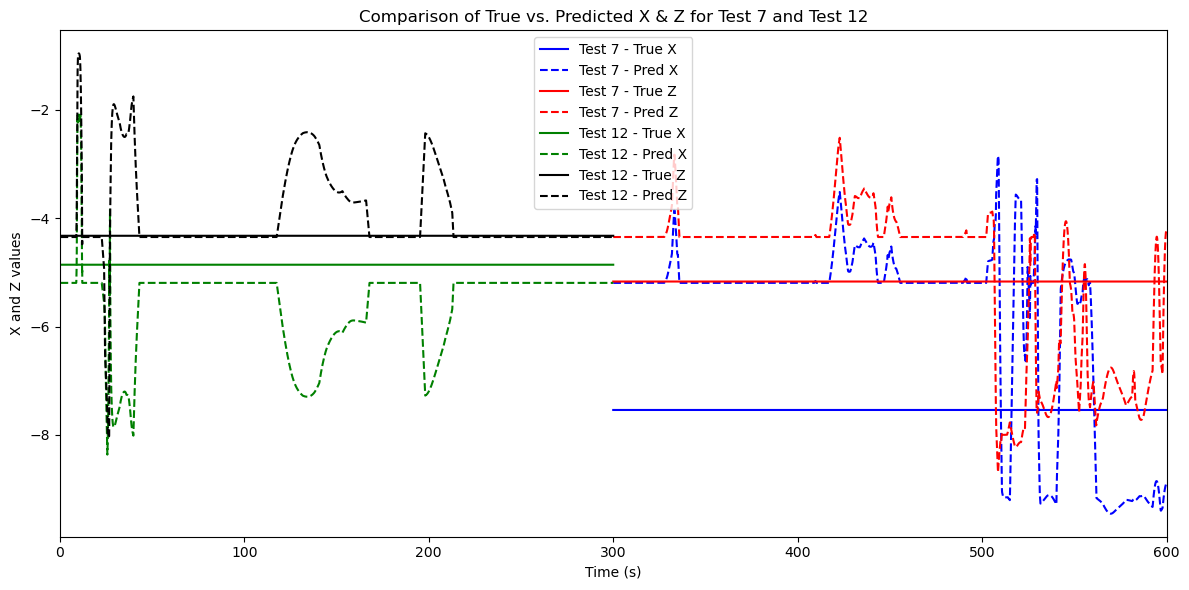

In [32]:
# TEST 7
t7 = df7[t].values
X7 = df7[inputs].values
y7_true = df7[['X', 'Z']].values
X7_scaled = scaler.transform(X7)
y7_pred = model2.predict(X7_scaled)

# TEST 12
t12 = df12[t].values
X12 = df12[inputs].values
y12_true = df12[['X', 'Z']].values
X12_scaled = scaler.transform(X12)
y12_pred = model2.predict(X12_scaled)

mask7 = (t7 >= 300) & (t7 <= 600)
mask12 = (t12 >= 0) & (t12 <= 300)
# test 7
t7_f = t7[mask7]
y7_true_f = y7_true[mask7]
y7_pred_f = y7_pred[mask7]

# test 12
t12_f = t12[mask12]
y12_true_f = y12_true[mask12]
y12_pred_f = y12_pred[mask12]


plt.figure(figsize = (12, 6))

plt.plot(t7_f, y7_true_f[:, 0], color = 'blue', label = 'Test 7 - True X')
plt.plot(t7_f, y7_pred_f[:, 0], '--', color = 'blue', label = 'Test 7 - Pred X')
plt.plot(t7_f, y7_true_f[:, 1], color = 'red', label = 'Test 7 - True Z')
plt.plot(t7_f, y7_pred_f[:, 1], '--', color = 'red', label = 'Test 7 - Pred Z')

plt.plot(t12_f, y12_true_f[:, 0], 'green', label = 'Test 12 - True X')
plt.plot(t12_f, y12_pred_f[:, 0], '--', color = 'green', label = 'Test 12 - Pred X')
plt.plot(t12_f, y12_true_f[:, 1], 'black', label = 'Test 12 - True Z')
plt.plot(t12_f, y12_pred_f[:, 1], '--', color = 'black', label = 'Test 12 - Pred Z')

plt.xlim(0, 600)
plt.xlabel('Time (s)')
plt.ylabel('X and Z values')
plt.title('Comparison of True vs. Predicted X & Z for Test 7 and Test 12')
plt.legend()
plt.tight_layout()
plt.show()

# 8.) PARITY PLOT for "Y" Prediction vs. "Y" actual

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

3526/3526 ━━━━━━━━━━━━━━━━━━━━ 1s 386us/step
3062/3062 ━━━━━━━━━━━━━━━━━━━━ 1s 419us/step


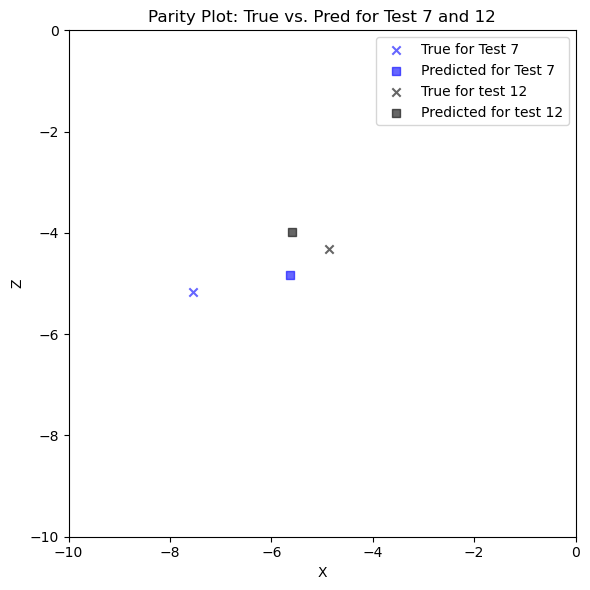

In [34]:
df7 = pd.read_csv('processed/07_test-7_range.csv')
df12 = pd.read_csv('processed/12_test-12_range.csv')

inputs = [f'p{i}' for i in range (1, 17)]
t = 'flow-time'

# test 7
t7 = df7[t].values
X7 = df7[inputs].values
y7_trueA = df7[['X', 'Z']].values
X7_scaled = scaler.transform(X7)
y7_predA = model2.predict(X7_scaled)
mask7 = (t7 >= 300) & (t7 <= 600)
y7_true_f = y7_trueA[mask7]
y7_pred_f = y7_predA[mask7]

# test 12
t12 = df12[t].values
X12 = df12[inputs].values
y12_trueA = df12[['X', 'Z']].values
X12_scaled = scaler.transform(X12)
y12_predA = model2.predict(X12_scaled)
mask12 = (t12 >= 0) & (t12 <= 300)
y12_true_f = y12_trueA[mask12]
y12_pred_f = y12_predA[mask12]

mean_pred7 = np.mean(y7_pred_f, axis=0)
med_true7 = np.median(y7_true_f, axis = 0)
mean_pred12 = np.mean(y12_pred_f, axis = 0)
med_true12 = np.median(y12_true_f, axis = 0)

plt.figure(figsize=(6,6))

low = min(med_true7.min(), med_true12.min(),
          mean_pred7.min(), mean_pred12.min())

high = max(med_true7.max(), med_true12.max(), 
           mean_pred7.max(), mean_pred12.max())

#plt.plot([low, high], [low, high], 'k--', label = 'Parity Line') 

plt.scatter(med_true7[0], med_true7[1], marker = 'x', color='blue', alpha = 0.6, label = 'True for Test 7')
plt.scatter(mean_pred7[0], mean_pred7[1], marker = 's', color = 'blue', alpha = 0.6, label = 'Predicted for Test 7')
plt.scatter(med_true12[0], med_true12[1], marker = 'x', color = 'black', alpha = 0.6, label = 'True for test 12')
plt.scatter(mean_pred12[0], mean_pred12[1], marker = 's', color = 'black', alpha = 0.6, label = 'Predicted for test 12')


plt.xlim([-10,0])
plt.ylim([-10,0])
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Parity Plot: True vs. Pred for Test 7 and 12')
plt.legend()
# plt.savefig('parity_plot_with_penalty.png', dpi = 200)
plt.tight_layout()
plt.show()

# 9.) ANN With Penalty -> Results

In [35]:
# PREDICTED X and Z
mean_x7, mean_z7 = mean_pred7
mean_x12, mean_z12 = mean_pred12

print(f"Test 7 -> X: {mean_x7:.4f}, Z: {mean_z7:.4f}")
print(f"Test 12 -> X: {mean_x12:.4f}, Z: {mean_z12:.4f}")

Test 7 -> X: -5.6361, Z: -4.8249
Test 12 -> X: -5.5864, Z: -3.9776


In [36]:
# ERROR X and Z
import math

true_x7, true_z7 = med_true7
pred_x7, pred_z7 = mean_pred7

true_x12, true_z12 = med_true12
pred_x12, pred_z12 = mean_pred12

err_x7 = abs(true_x7 - pred_x7) / (true_x7) * 100
err_z7 = abs(true_z7 - pred_z7) / (true_z7) * 100
err_x12 = abs(true_x12 - pred_x12) / (true_x12) * 100
err_z12 = abs(true_z12 - pred_z12) / (true_z12) * 100

print(f"Test 7 Error -> X = {err_x7:.2f}%, Z = {err_z7}%")
print(f"Test 12 Error -> X = {err_x12:.2f}%, Z = {err_z12}%")

Test 7 Error -> X = -25.23%, Z = -6.616072502301204%
Test 12 Error -> X = -15.03%, Z = -7.970891026773999%


In [37]:
# DIST(D)

true_x7, true_z7 = med_true7
pred_x7, pred_z7 = mean_pred7

true_x12, true_z12 = med_true12
pred_x12, pred_z12 = mean_pred12

d7 = np.sqrt((true_x7 - pred_x7)**2 + (true_z7 - pred_z7)**2)
d12 = np.sqrt((true_x12 - pred_x12)**2 + (true_z12 - pred_z12)**2)

print(f"Test 7 dist(d) = {d7:.4f}")
print(f"Test 12 dist(d) = {d12:.4f}")

Test 7 dist(d) = 1.9325
Test 12 dist(d) = 0.8071


# 10.) Save This Notebook

In [ ]:
np.savez_compressed(
    'parity_with_penalty.npz',
    med_true7 = med_true7,
    mean_pred7 = mean_pred7, 
    med_true12 = med_true12,
    mean_pred12 = mean_pred12
)

# Other 

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import r2_score
# # unpack
# true_X, true_Z = y_trueA[:,0], y_trueA[:,1]
# pred_X, pred_Z = y_predA[:,0], y_predA[:,1]

# average_trueX = np.median(true_X)
# average_predX = np.mean(pred_X[10000:20000])
# average_trueZ = np.median(true_Z)
# average_predZ = np.mean(pred_Z[10000:20000])

# # find common axis limits
# all_vals = np.hstack([average_trueX, average_predX, average_trueZ, average_predZ])
# vmin, vmax = all_vals.min(), all_vals.max()



# # compute 10% padding
# pad = 0.1 * (vmax - vmin)

# fig, ax = plt.subplots(figsize=(6,6))

# # scatter
# ax.scatter(average_trueX, average_trueZ, alpha=0.6, label='True', marker='o')
# ax.scatter(average_predX, average_predZ, alpha=0.6, label='Predicted', marker='s')
# # ax.scatter (pred_X[100:], pred_Z[100:],marker='s', alpha= 0.1)
# # 45° line
# # ax.plot([vmin, vmax], [vmin, vmax], 'k--', linewidth=1)

# # set limits with padding
# # ax.set_xlim(vmin - pad, vmax + pad)
# # ax.set_ylim(vmin - pad, vmax + pad)

# plt.xlim([-10,0])
# plt.ylim([-10,0])
# # equal aspect
# # ax.set_aspect('equal', 'box')
# # 
# # ax.set_xlabel('True Value')
# # ax.set_ylabel('Predicted Value')
# # ax.set_title('Parity Plot for X and Z')

# ax.set_xlabel('X')
# ax.set_ylabel('Z')
# ax.set_title('Comparing Leak Points')
# ax.legend()
# plt.tight_layout()
# plt.show()



# print(average_trueX) 
# print(average_predX)
# print(average_trueZ) 
# print(average_predZ) 

In [ ]:
# import numpy as np 

# np.savez(
#     "results_with_penalty.npz", 
#     y7_trueA= y7_trueA, 
#     y7_predA = y7_predA,
#     y12_trueA= y12_trueA,
#     y12_predA= y12_predA
# ) 

# print("Notebook results saved.") 

In [ ]:
# import numpy as np 

# np.savez(
#     "results_for_everything.npz", 
#     y_trueA= y_trueA, 
#     y_predA = y_predA
# ) 

# print("Notebook results saved.") 

In [ ]:
# # TEST 7
# t7 = df7[t].values
# X7 = df7[inputs].values
# y7_true = df7[['X', 'Z']].values
# X7_scaled = scaler.transform(X7)
# y7_pred = model2.predict(X7_scaled)

# # TEST 12
# t12 = df12[t].values
# X12 = df12[inputs].values
# y12_true = df12[['X', 'Z']].values
# X12_scaled = scaler.transform(X12)
# y12_pred = model2.predict(X12_scaled)

# mask7 = (t7 >= 300) & (t7 <= 600)
# mask12 = (t12 >= 0) & (t12 <= 300)
# # test 7
# t7_f = t7[mask7]
# y7_true_f = y7_true[mask7]
# y7_pred_f = y7_pred[mask7]

# # test 12
# t12_f = t12[mask12]
# y12_true_f = y12_true[mask12]
# y12_pred_f = y12_pred[mask12]


# plt.figure(figsize = (12, 6))

# plt.plot(t7_f, y7_true_f[:, 0], color = 'blue', label = 'Test 7 - True X')
# plt.plot(t7_f, y7_pred_f[:, 0], '--', color = 'blue', label = 'Test 7 - Pred X')
# plt.plot(t7_f, y7_true_f[:, 1], color = 'red', label = 'Test 7 - True Z')
# plt.plot(t7_f, y7_pred_f[:, 1], '--', color = 'red', label = 'Test 7 - Pred Z')

# plt.plot(t12_f, y12_true_f[:, 0], 'green', label = 'Test 12 - True X')
# plt.plot(t12_f, y12_pred_f[:, 0], '--', color = 'green', label = 'Test 12 - Pred X')
# plt.plot(t12_f, y12_true_f[:, 1], 'black', label = 'Test 12 - True Z')
# plt.plot(t12_f, y12_pred_f[:, 1], '--', color = 'black', label = 'Test 12 - Pred Z')

# plt.xlim(10, 600)
# plt.xlabel('Time (s)')
# plt.ylabel('X and Z values')
# plt.title('Comparison of True vs. Predicted X & Z for Test 7 and Test 12')
# plt.legend()
# plt.tight_layout()
# plt.show()